In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pysr import PySRRegressor, TemplateExpressionSpec

# Multitask

In [3]:
n_samples = 100

In [4]:
X1, y1 = make_circles(n_samples=n_samples, noise=0.1, factor=0.4)
X1[:, 0] += 2
X1[:, 1] += 2

X2, y2 = make_circles(n_samples=n_samples, noise=0.1, factor=0.4)

X_all = np.vstack([X1, X2])
y_all = np.hstack([y1, y2])

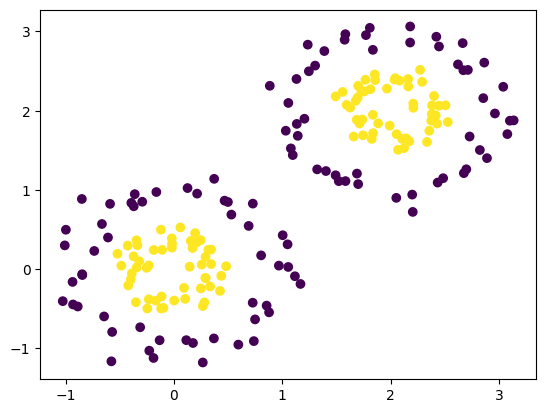

In [5]:
plt.scatter(X_all[:, 0], X_all[:, 1], c=y_all)

In [6]:
loss_2_ds="""
import Pkg
Pkg.add("Optim")
Pkg.add("DynamicExpressions")

using SymbolicRegression
using Optim
using DynamicExpressions: 
    get_scalar_constants, 
    count_scalar_constants, 
    set_scalar_constants!

function my_eval(tree, x_, y_, params, options)
    _, refs = get_scalar_constants(tree)
    set_scalar_constants!(tree, params, refs)
    
    prediction, flag = eval_tree_array(tree, x_, options)
    if !flag
        return Inf
    end
    
    prediction = (prediction .>= 0.5)
    not_accuracy = sum(prediction .!= y_) / length(prediction)
    return not_accuracy
end


function multitask_loss(tree, dataset:: Dataset{T, L}, options)::L where {T, L}
    num_params = count_scalar_constants(tree)

    if num_params == 0
        return L(Inf)
    end

    # MODIFIABLE BLOCK
    d1 = [dataset.X[:, 1:100], dataset.y[1:100]] 
    d2 = [dataset.X[:, 101:200], dataset.y[101:200]]
    datasets = [d1, d2]

    total_loss = 0.0
    initial_params = ones(num_params)
    for subds in datasets        
        res = Optim.optimize(p -> my_eval(tree, subds[1], subds[2], p, options), initial_params)
        total_loss += Optim.minimum(res)
    end
    return total_loss
end
"""

In [7]:
model = PySRRegressor(
    niterations=100,
    unary_operators=["exp"],
    binary_operators=["+", "*"],
    model_selection="best",
    loss_function=loss_2_ds,
    procs=8
)

In [8]:
%%time
model.fit(X_all, y_all)

/home/bukkacha/.local/lib/python3.10/site-packages/pysr/sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
   Resolving package versions...


Compiling Julia backend...


  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
[ Info: Started!



Expressions evaluated per second: 5.730e+03
Progress: 39 / 3100 total iterations (1.258%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.000e+00  1.594e+01  y = 4.7915
3           8.400e-01  8.718e-02  y = x₀ + 1.0328
5           8.100e-01  1.818e-02  y = 0.70469 + (x₀ * x₁)
6           7.800e-01  3.774e-02  y = exp((x₁ * x₀) * 4.9054)
7           7.700e-01  1.290e-02  y = (x₀ + 1.1006) * (1.0868 + x₁)
9           7.500e-01  1.316e-02  y = (x₀ + (1.5383 + x₀)) * (1.0143 + x₁)
10          6.200e-01  1.904e-01  y = (((x₁ * -1.5471) * x₁) + 1.0246) * exp(x₀)
16          6.100e-01  2.710e-03  y = (x₁ + (1.7439 + ((x₀ * x₀) * ((-4.1985 + x₀) * exp(x₁)...
                                      )))) + x₁
18          5.500e-01  5.177e-02  y = ((x₁ + 1.9393) + (x₀ * ((x₀ * (x₀ + -5.138))

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  loss  \
	0        0.000000                                          4.7915487  1.00   
	1        0.087177                                     x0 + 1.0328125  0.84   
	2        0.037054                              (x1 * x0) + 0.6450537  0.78   
	3        0.006452                (x0 + 1.1005844) * (1.0868378 + x1)  0.77   
	4  >>>>  0.184922                   exp((x1 * (x1 * -1.75625)) + x0)  0.64   
	5        0.015748         x1 + (((x0 * -3.4194837) * x0) + 1.343672)  0.63   
	6        0.016000   (((x1 * -1.5470703) * x1) + 1.0246093) * exp(x0)  0.62   
	7        0.033346    exp((x0 * x0) * (((x1 * x1) * -30.10625) + x0))  0.58   
	8        0.148420  exp((-0.40271837 * ((x1 * x1) + exp(x0 * 2.137...  0.50   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           7  
	4           8  
	5           9  
	6          10  
	7          12  
	8          13  
]

  - outputs/20250220_145658_8INAbp/hall_of_fame.csv


In [9]:
model.sympy()

exp(x0 + x1*x1*(-1.75625))

In [10]:
y_pred = model.predict(X_all)
y_pred = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_all, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.6250
